# Setup

In [1]:
import setup
import os

# Dataset Downloading

Covid-19 Image Classification

In [2]:
#!curl -L -o /content/sample_data/covid19-image-dataset.zip\
#  https://www.kaggle.com/api/v1/datasets/download/pranavraikokte/covid19-image-dataset

In [3]:
#from zipfile import ZipFile
#with ZipFile('/content/sample_data/covid19-image-dataset.zip') as zp:
#  zp.extractall('/content/sample_data/')

# Data Loading

In [4]:
# Checking Biggest Image Sizes
from glob import glob
from setup import DATA_PATH
import os
from PIL import Image
imgs = glob(os.path.join(DATA_PATH, 'train', '*', '*.jpg'), recursive=True) + glob(os.path.join(DATA_PATH, 'train', '*', '*.png'), recursive=True) + glob(os.path.join(DATA_PATH, 'train', '*', '*.jpeg'), recursive=True)

widths = []
heights = []

for img in imgs:
    pil_image = Image.open(img)
    widths.append(pil_image.width)
    heights.append(pil_image.height)

print(f'Largest: width {max(widths)} and height {max(heights)}')
print(f'Mean values: width {sum(widths)/len(widths)} and height {sum(heights)/len(heights)}')

Largest: width 4248 and height 4095
Mean values: width 1717.9721115537848 and height 1439.98406374502


In [5]:
from torchvision import datasets, transforms
from setup import IMAGE_WIDTH, IMAGE_HEIGHT
from data.loading import load_data
from math import ceil

transform = transforms.Compose([transforms.Resize(size=(IMAGE_WIDTH, IMAGE_HEIGHT)), transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
train_ds, test_ds = load_data(transform)


We might not have to create a custom dataset, because we can use ImageFolder to create a dataset from an image folder with an organized structure. It will automatically associate the class names to images according to folder names.

https://debuggercafe.com/pytorch-imagefolder-for-training-cnn-models/

Images loaded are of different sizes, which would cause a
```
RuntimeError: stack expects each tensor to be equal size, but got [3, 3480, 4248] at entry 0 and [3, 1303, 1458] at entry 1

```

We can fix that by assuring all images are of the same size. Use a transform for that.

https://discuss.pytorch.org/t/runtimeerror-stack-expects-each-tensor-to-be-equal-size-but-got-3-224-224-at-entry-0-and-3-224-336-at-entry-3/87211

Apparently, we can normalize the channels to make sure brighter colors won't be of more importance. Use a transform for that.

https://stats.stackexchange.com/questions/211436/why-normalize-images-by-subtracting-datasets-image-mean-instead-of-the-current

# Analyzing Data

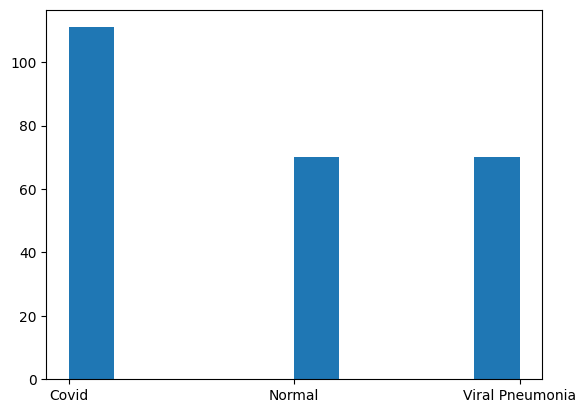

,Img_Uri
Class,
0,111
1,70
2,70


In [6]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(train_ds.imgs)
df = df.rename(columns={0: 'Img_Uri', 1: 'Class'})
classes = df.loc[:, 'Class']

plt.hist(classes)
plt.xticks([0, 1, 2], labels=train_ds.classes)
plt.show()

df.groupby(['Class']).count()

# Modifying Data

-> Undersampling

In [7]:
len(train_ds)

251

In [8]:
i = 0
iteration = 0
new_imgs = []
targets = []
samples = []
for img in train_ds.imgs:
  if img[1] == 0:
    if i >= 70:
      continue
    i += 1

  targets.append(train_ds.targets[iteration])
  new_imgs.append(img)
  samples.append(train_ds.samples[iteration])
  iteration += 1

train_ds.imgs = new_imgs
train_ds.targets = targets
train_ds.samples = samples

In [9]:
NUM_IMGS = len(train_ds.imgs)
NUM_BATCHES = ceil(NUM_IMGS/setup.BATCH_SIZE)

In [10]:
len(train_ds)

210

## Loader

In [11]:
from torch.utils.data import Dataset, DataLoader
import torch
from setup import BATCH_SIZE


loader = DataLoader(
    dataset=train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

iterable_ds = iter(loader)

# Declaring Components

- Model
- Optimizer
- Loss Function
- Scheduler

## Making Model

In [12]:
from torch import nn
from setup import FINE_TUNE
from model.load_model import create_model

model = create_model(fine_tune=FINE_TUNE)

## Setting Up Optimizer, Loss Function and Scheduler

In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=setup.LEARNING_RATE, momentum=0.9)
loss = nn.CrossEntropyLoss()

# Setting Up Scheduler
from torch.optim import lr_scheduler

scheduler = lr_scheduler.StepLR(
    optimizer,
    step_size=10,
    gamma=0.5
)

# Training

Apparently, to run on the GPU, we have to send the data itself to the GPU. We can do so with the batches. The loss function also needs the labels to be loaded on the GPU.

https://discuss.pytorch.org/t/how-to-load-all-data-into-gpu-for-training/27609/22?page=2

Also, we need the weights to be on the GPU. We can do that by using the model itself, sending it to the GPU as well.

https://discuss.pytorch.org/t/how-to-load-all-data-into-gpu-for-training/27609/34?page=2

In [14]:
# GPU or CPU Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device=device)

Tqdm is a simple library that can be used to generate a loading bar on loops.

https://github.com/tqdm/tqdm

In [15]:
from model.train import train

train(
    model=model,
    num_batches=NUM_BATCHES,
    num_epochs=setup.NUM_EPOCHS,
    device=device,
    optimizer=optimizer,
    scheduler=scheduler,
    dataset=train_ds,
    loss=loss,
    num_imgs=NUM_IMGS
)

Epoch 0: 100%|██████████| 20/20 [00:01<00:00, 10.48it/s]

Epoch 0 | Accuracy: 72.8571%



Epoch 1: 100%|██████████| 20/20 [00:01<00:00, 10.25it/s]

Epoch 1 | Accuracy: 82.3810%



Epoch 2: 100%|██████████| 20/20 [00:01<00:00, 10.30it/s]

Epoch 2 | Accuracy: 82.3810%



Epoch 3: 100%|██████████| 20/20 [00:01<00:00, 10.15it/s]

Epoch 3 | Accuracy: 78.0952%



Epoch 4: 100%|██████████| 20/20 [00:01<00:00, 10.25it/s]

Epoch 4 | Accuracy: 81.9048%
Switching to model with accuracy of 82.3810%


tensor(82.3810, device='cuda:0')

# Training With Stratified Data

In [16]:
import numpy as np

X = np.array(train_ds.imgs + test_ds.imgs)
y = np.array(train_ds.targets + test_ds.targets)

In [17]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

split_sets = skf.split(X, y)


In [ ]:
from tqdm import tqdm
import PIL

class custom_dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform):
        super().__init__()
        self.X = X
        self.y = y
        self.transform = transform

    def __getitem__(self, index):

        file_path = self.X[index][0]
        label = self.y[index]

        pil_image = PIL.Image.open(file_path)
        pil_image = pil_image.convert('RGB')

        # Reference: https://stackoverflow.com/questions/76137400/how-to-feed-on-single-image-into-a-pytorch-cnn
        model_input = self.transform(pil_image).float().unsqueeze(0)

        return model_input[0], label # we return the image data [num_channels, width, height] and the corresponding label

    def __len__(self):
        return len(self.X)
        

# Based on documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

for i, (train_index, test_index) in enumerate(split_sets):

    # Loading Stratified Data ======================

    ds = custom_dataset(X[train_index], y[train_index], transform) # custom dataset, with images chosen by Stratified K Fold
    num_imgs = len(train_index)
    
    # Creating New Model and Components ============

    model = create_model(fine_tune=FINE_TUNE)
    model = model.train()
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=setup.LEARNING_RATE, momentum=0.9)
    loss = nn.CrossEntropyLoss()

    scheduler = lr_scheduler.StepLR(
        optimizer,
        step_size=10,
        gamma=0.5
    )

    # Training =====================================
    accuracy = train(
        model=model,
        num_batches=NUM_BATCHES,
        num_epochs=setup.NUM_EPOCHS,
        device=device,
        optimizer=optimizer,
        scheduler=scheduler,
        dataset=ds,
        loss=loss,
        num_imgs=num_imgs,
        verbose=False
    )
    print(f'Fold {i}')
    print(f'Train Accuracy: {accuracy:.4f}%')

    # Testing =======================================

    model = model.eval()

    accuracy = 0
    test_X = X[test_index]
    test_y = y[test_index]
    ds = custom_dataset(X, y, transform)
    num_imgs = len(test_y)

    for index in test_index:

        model_input, label = ds.__getitem__(index)
        model_input = model_input.to(device)

        ms = model_input.shape

        model_input = model_input.view(1, ms[0], ms[1], ms[2]) # create a single batch with the image data (wrap it in a tensor)
        
        probabilities = torch.softmax(model(model_input), dim=1)
        prediction = torch.argmax(probabilities).item()

        if prediction == label:
            accuracy += 1
    print(f'Test Accuracy: {accuracy*100/num_imgs:.4f}%\n')

Fold 0
Train Accuracy: 76.3636%
Test Accuracy: 92.8571%

Fold 1
Train Accuracy: 80.5430%
Test Accuracy: 65.4545%

Fold 2
Train Accuracy: 77.8281%
Test Accuracy: 70.9091%

Fold 3
Train Accuracy: 77.8281%
Test Accuracy: 76.3636%

Fold 4
Train Accuracy: 80.0905%
Test Accuracy: 74.5455%



# Evaluation

Evaluating with Test Data

In [19]:
from data.evaluation import evaluate_model

#evaluate_model(model=model,
#               test_data=test_ds,
#               batch_size=BATCH_SIZE
#               )

In [20]:
from data.evaluation import evaluate_single

evaluate_single(model=model, classes_list=['Covid', 'Normal', 'Viral Pneumonia'], device=device)

Testing Against Images of Class Viral Pneumonia: 100%|██████████| 20/20 [00:00<00:00, 75.97it/s]


Accuracy: 56/66 | 84.8485%


# Saving Model

In [ ]:
from model.save_model import save_model

save_model(model=model, optimizer=optimizer)